# Exercice 1
**Auteurs : Pedro Costa, Louis Delabays, Jonathan Guerne**

## Partie a)

### a) import de MNSIT

In [1]:
from sklearn import datasets
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os

# This is a bit of magic to make matplotlib figures appear inline in the notebook
# rather than in a new window. Also setting some parameters for display.
%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 10.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

In [2]:
# This is a method to read the MNIST dataset from a ROOT directory
def load_MNIST(ROOT):
  '''load all of mnist
  training set first'''
  Xtr = []
  train = pd.read_csv(os.path.join(ROOT, 'mnist_train.csv'))
  X = np.array(train.drop('label', axis=1))
  Ytr = np.array(train['label'])
  # With this for-loop we give the data a shape of the acctual image (28x28)
  # instead of the shape in file (1x784)
  for row in X:
      Xtr.append(row.reshape(28,28))
  # load test set second
  Xte = []
  test = pd.read_csv(os.path.join(ROOT, 'mnist_test.csv'))
  X = np.array(test.drop('label', axis=1))
  Yte = np.array(test['label'])
  # same reshaping
  for row in X:
      Xte.append(row.reshape(28,28))
  
  return np.array(Xtr), np.array(Ytr), np.array(Xte), np.array(Yte)

In [3]:
# Load the raw MNIST data.
mnist_dir = 'mnist/'   
X_train, y_train, X_test, y_test = load_MNIST(mnist_dir)

### b) affichage de digits

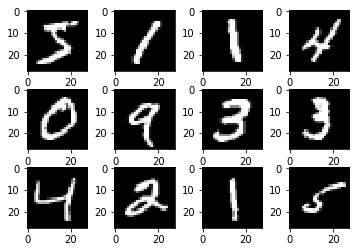

In [4]:
f, axarr = plt.subplots(3, 4)

for k in range(12):
    i = int(k % 3);
    j = int(k / 3);
    axarr[i, j].imshow(X_train[k])
f.subplots_adjust(hspace=0.3)

plt.show()

### c) finalisation des ensembles d'entraînement et de test. Balancement des données 

In [5]:
def get_resize_data(y, x, number_per_label=None, reshape=False):
    """y => vecteur de label, x => matrice de donnee, number_per_label => nombre de valeur par label,
    si non préciser calculé automatiquement"""
    
    if number_per_label is None:
        number_per_label = min([y[y==i].shape[0] for i in range(10)])
    ids = np.sort(np.concatenate([np.argwhere(y==i).flatten()[:number_per_label] for i in range(10)]))
    if reshape:
        return x[ids].reshape((number_per_label * 10,-1)),y[ids]
    else:
        return x[ids],y[ids]
    

In [6]:
# final x train et final y train
fx_train,fy_train = get_resize_data(y_train,X_train,number_per_label = 200,reshape=True)

# final x test et final y test
fx_test, fy_test = get_resize_data(y_test,X_test, number_per_label = 100, reshape=True)

## Partie b)

In [7]:
import itertools
from sklearn import svm, metrics
from sklearn.model_selection import GridSearchCV

In [8]:
param_grid = [
  {'C': [1, 10, 100, 1000], 'kernel': ['linear']},
  {'C': [1, 10, 100, 1000], 'gamma': [0.001, 0.0001], 'kernel': ['rbf','poly']}
 ]

clf = svm.SVC()
grid_clsf = GridSearchCV(estimator=clf,param_grid=param_grid)
grid_clsf.fit(fx_train,fy_train)

bst_classifier = grid_clsf.best_estimator_
bst_params = grid_clsf.best_params_

In [9]:
preds = bst_classifier.predict(fx_test)
print(metrics.classification_report(fy_test, preds))

             precision    recall  f1-score   support

          0       0.93      0.96      0.95       100
          1       0.87      0.99      0.93       100
          2       0.91      0.89      0.90       100
          3       0.91      0.78      0.84       100
          4       0.87      0.93      0.90       100
          5       0.86      0.88      0.87       100
          6       0.94      0.91      0.92       100
          7       0.88      0.91      0.90       100
          8       0.87      0.78      0.82       100
          9       0.91      0.91      0.91       100

avg / total       0.89      0.89      0.89      1000



## Partie d)

In [10]:
print("best classifier kernel : {}".format(bst_classifier.kernel))
print("best params found : {}".format(bst_params))

best classifier kernel : poly
best params found : {'C': 1, 'gamma': 0.001, 'kernel': 'poly'}


In [11]:
cm = metrics.confusion_matrix(fy_test, preds)
accuracy = metrics.accuracy_score(fy_test,preds)

pour déterminer quels digits ont été le mieux/moins bien reconnu par rapport à d'autres la meilleure solution est de faire une matrice de confusion.

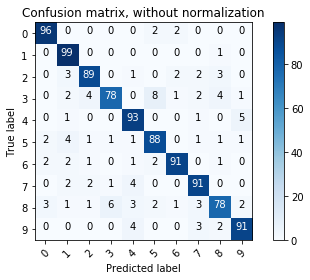

In [12]:
# http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html
# un exemple d'affichage de matrice de confusion
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()


np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cm, classes=[str(i) for i in range(10)],
                      title='Confusion matrix, without normalization')

plt.show()

On remarque 2 classes qui ont plus de peine à être reconnu correctement : 8 et 3. Beaucoup de 8 mal classé on été confondu avec des 3 mais l'inverse n'est pas nécessairement vrai.

augementer la taille du training et testing set augemente énormément la durée du grid search. Ce qui est compréhensible quand on réléfchit à la quantité de combinaison que va devoir tester l'algorithme. Les 3 ont plutôt été confondu avec des 5. Les classes 1 et 0 sont les deux classes avec les meilleurs prédictions.